# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts accross multiple years.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

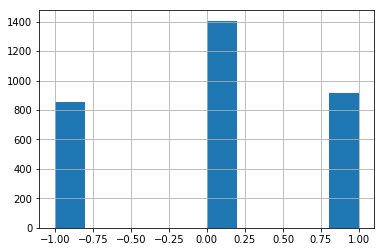

In [12]:
gold['target'].hist()

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

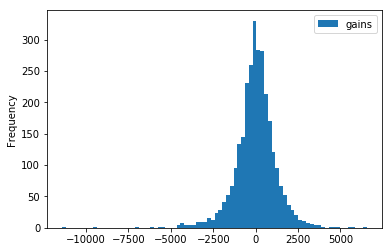

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

### Investigate suitable stop-loss value

Below are cummulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



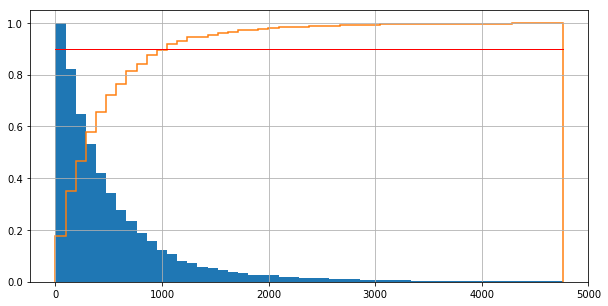

In [18]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

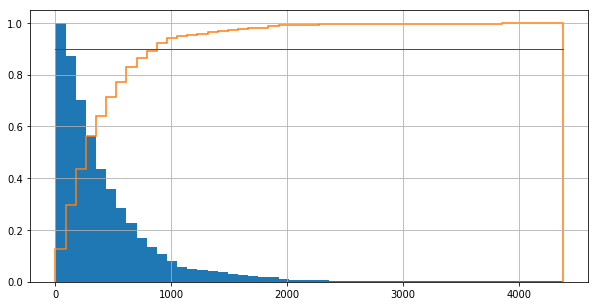

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')

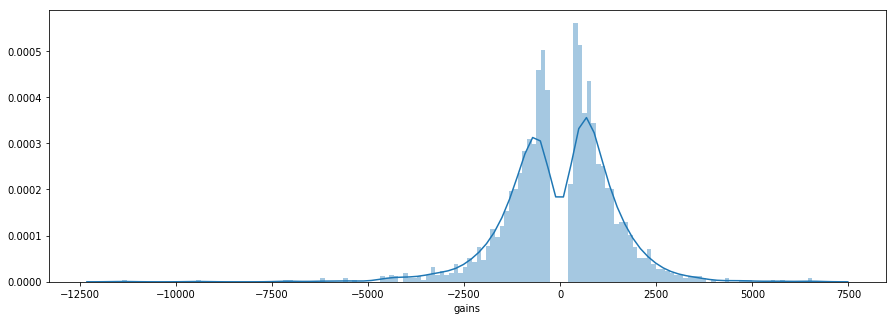

In [22]:
sr = gold_gains_train.loc[gold_gains_train.index < '2018-01-01'][gold_gains_train.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

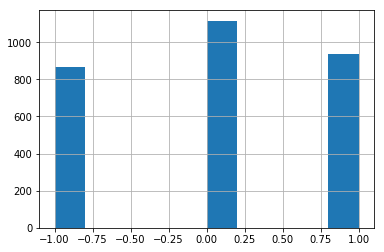

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

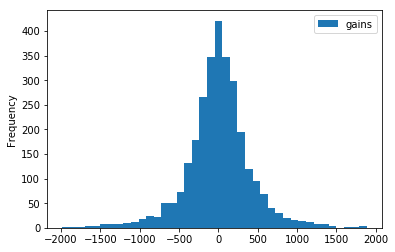

In [26]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

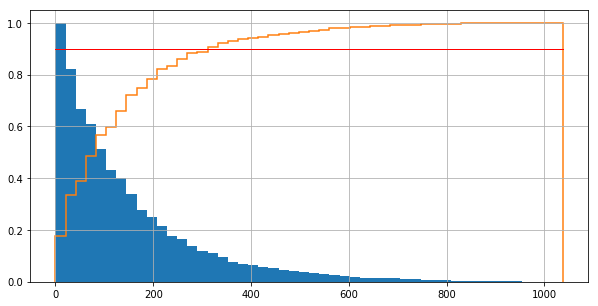

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

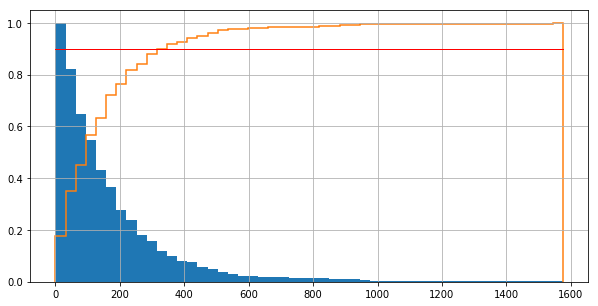

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


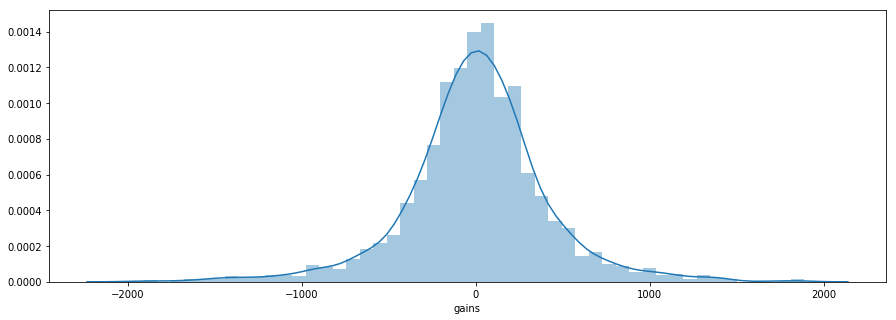

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


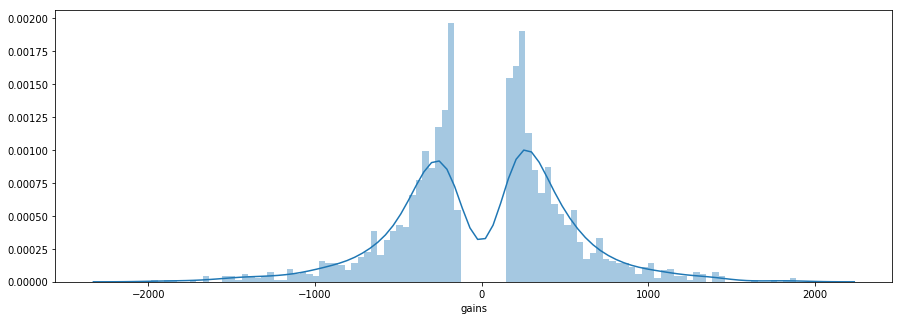

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

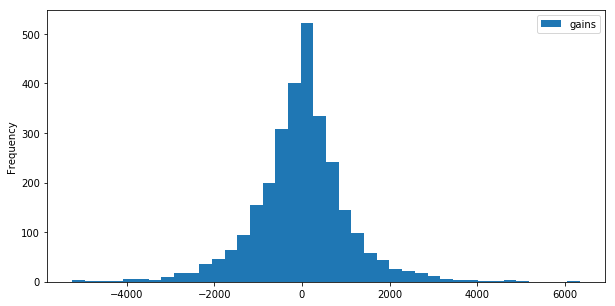

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

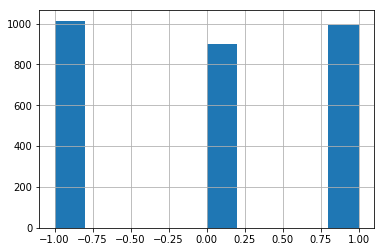

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

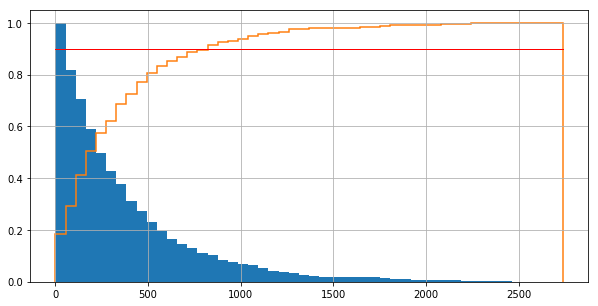

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

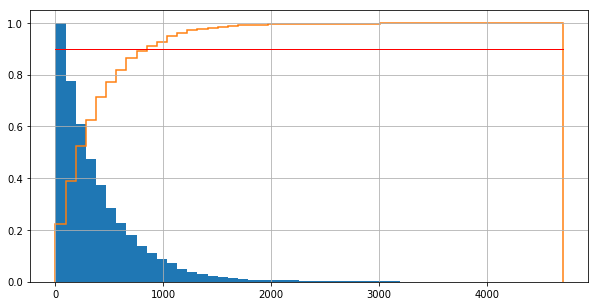

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

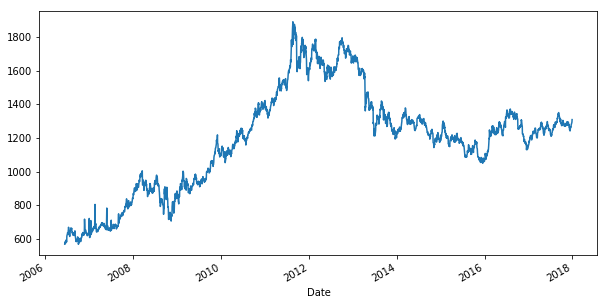

In [39]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

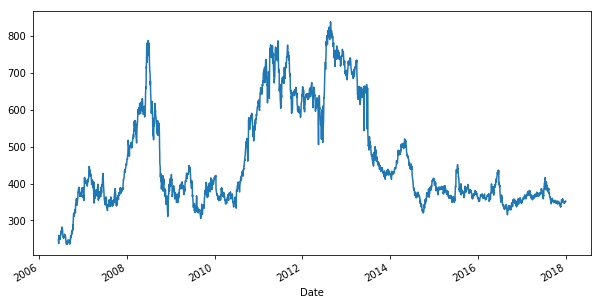

In [40]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

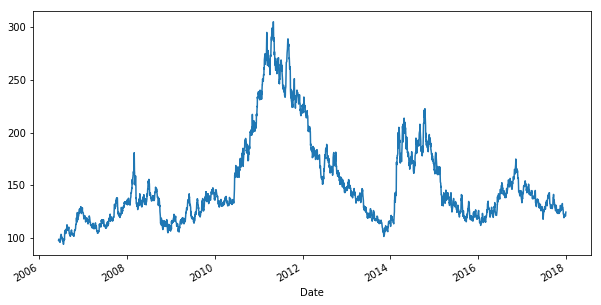

In [41]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

In [42]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [43]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [44]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [45]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


In [46]:
gold_data.shape

(2668, 2545)

In [47]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [48]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [49]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [50]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [51]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new')
# out = LocalOutlierFactor()
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [52]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 1
inliers: 1932


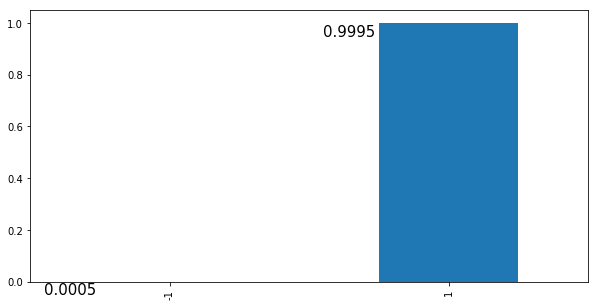

In [53]:
plot_hist_perc(modified_gold)

outliers: 10
inliers: 1920


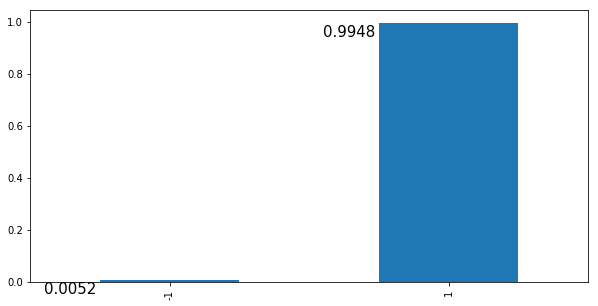

In [54]:
plot_hist_perc(modified_corn)

Coffee data contains unusualy big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 336
inliers: 1587


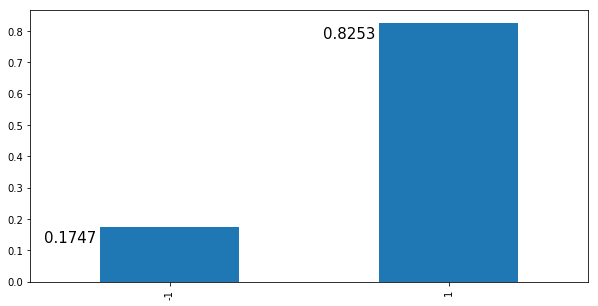

In [55]:
plot_hist_perc(modified_coffee)

In [56]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf[80] = df.loc[df.index < '2018-1-1'][2544].values
    # print(gdf.head())
    # gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    # gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test[80] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

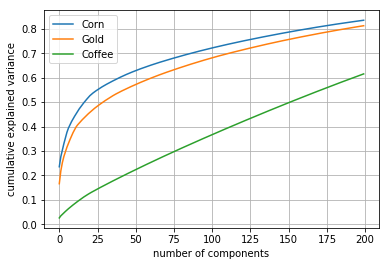

In [57]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

It is intereresting Corn is best expalined by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that pca transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components then PCA transformation is not suitable. Therefore coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [58]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [59]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [60]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [61]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [243]:
from numpy import size
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            # print(abs(v[0]), type(v[0]))
            if size(v) > 1:
                v = v[0]
            if abs(v) > target:
                # print('hit', abs(v[0]))
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(v)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regresssor

# LightGBM Classifier
I tried training lightGBM classifier to train on data with created labels.

- gold 92% gains
- corn -12% losses
- coffee no change - no trade was triggered

In [313]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
# param['objective'] = 'binary'
param['objective'] = 'regression'
# param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'poisson'
param['learning_rate'] = 0.1
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's poisson: -150.372
[2]	valid_0's poisson: -376.586
[3]	valid_0's poisson: 74.3122
[4]	valid_0's poisson: -157.696
[5]	valid_0's poisson: -74.4413
[6]	valid_0's poisson: 178.701
[7]	valid_0's poisson: -382.493
[8]	valid_0's poisson: 43.8891
[9]	valid_0's poisson: 158.818
[10]	valid_0's poisson: -131.723
[11]	valid_0's poisson: -241.21
[12]	valid_0's poisson: -521.731
[13]	valid_0's poisson: -825.445
[14]	valid_0's poisson: -603.378
[15]	valid_0's poisson: -249.549
[16]	valid_0's poisson: 111.017
[17]	valid_0's poisson: 190.577
[18]	valid_0's poisson: 70.265
[19]	valid_0's poisson: 153.512
[20]	valid_0's poisson: 188.348
[21]	valid_0's poisson: -218.057
[22]	valid_0's poisson: -41.3327
[23]	valid_0's poisson: 134.611
[24]	valid_0's poisson: -152.314
[25]	valid_0's poisson: -245.84
[26]	valid_0's poisson: -261.196
[27]	valid_0's poisson: -101.232
[28]	valid_0's poisson: -505.999
[29]	valid_0's poisson: -268.31
[30]	valid_0's poisson: -379.082
[31]	valid_0's poisson: -465.688


[285]	valid_0's poisson: -565.571
[286]	valid_0's poisson: -527.043
[287]	valid_0's poisson: -527.859
[288]	valid_0's poisson: -545.378
[289]	valid_0's poisson: -544.927
[290]	valid_0's poisson: -524.354
[291]	valid_0's poisson: -524.288
[292]	valid_0's poisson: -523.6
[293]	valid_0's poisson: -505.53
[294]	valid_0's poisson: -505.581
[295]	valid_0's poisson: -504.529
[296]	valid_0's poisson: -504.957
[297]	valid_0's poisson: -504.738
[298]	valid_0's poisson: -506.706
[299]	valid_0's poisson: -525.459
[300]	valid_0's poisson: -539.882
[301]	valid_0's poisson: -504.241
[302]	valid_0's poisson: -550.057
[303]	valid_0's poisson: -511.563
[304]	valid_0's poisson: -511.41
[305]	valid_0's poisson: -548.852
[306]	valid_0's poisson: -511.288
[307]	valid_0's poisson: -511.747
[308]	valid_0's poisson: -540.852
[309]	valid_0's poisson: -554.768
[310]	valid_0's poisson: -554.585
[311]	valid_0's poisson: -555.364
[312]	valid_0's poisson: -554.163
[313]	valid_0's poisson: -553.426
[314]	valid_0's po

[543]	valid_0's poisson: -597.095
[544]	valid_0's poisson: -597.214
[545]	valid_0's poisson: -597.188
[546]	valid_0's poisson: -596.851
[547]	valid_0's poisson: -596.934
[548]	valid_0's poisson: -597.021
[549]	valid_0's poisson: -596.77
[550]	valid_0's poisson: -596.626
[551]	valid_0's poisson: -596.694
[552]	valid_0's poisson: -596.622
[553]	valid_0's poisson: -596.519
[554]	valid_0's poisson: -596.463
[555]	valid_0's poisson: -596.397
[556]	valid_0's poisson: -596.309
[557]	valid_0's poisson: -596.153
[558]	valid_0's poisson: -596.145
[559]	valid_0's poisson: -595.981
[560]	valid_0's poisson: -596.011
[561]	valid_0's poisson: -596.104
[562]	valid_0's poisson: -596.141
[563]	valid_0's poisson: -596.095
[564]	valid_0's poisson: -596.032
[565]	valid_0's poisson: -596.025
[566]	valid_0's poisson: -596.305
[567]	valid_0's poisson: -596.324
[568]	valid_0's poisson: -596.503
[569]	valid_0's poisson: -596.468
[570]	valid_0's poisson: -596.443
[571]	valid_0's poisson: -596.441
[572]	valid_0's

[821]	valid_0's poisson: -603.831
[822]	valid_0's poisson: -603.833
[823]	valid_0's poisson: -603.848
[824]	valid_0's poisson: -603.853
[825]	valid_0's poisson: -603.849
[826]	valid_0's poisson: -603.847
[827]	valid_0's poisson: -603.855
[828]	valid_0's poisson: -603.799
[829]	valid_0's poisson: -603.777
[830]	valid_0's poisson: -603.839
[831]	valid_0's poisson: -603.782
[832]	valid_0's poisson: -603.83
[833]	valid_0's poisson: -603.753
[834]	valid_0's poisson: -603.785
[835]	valid_0's poisson: -603.811
[836]	valid_0's poisson: -603.682
[837]	valid_0's poisson: -603.667
[838]	valid_0's poisson: -603.69
[839]	valid_0's poisson: -603.698
[840]	valid_0's poisson: -603.7
[841]	valid_0's poisson: -603.656
[842]	valid_0's poisson: -603.701
[843]	valid_0's poisson: -603.703
[844]	valid_0's poisson: -603.704
[845]	valid_0's poisson: -603.679
[846]	valid_0's poisson: -603.709
[847]	valid_0's poisson: -603.713
[848]	valid_0's poisson: -603.703
[849]	valid_0's poisson: -603.691
[850]	valid_0's po

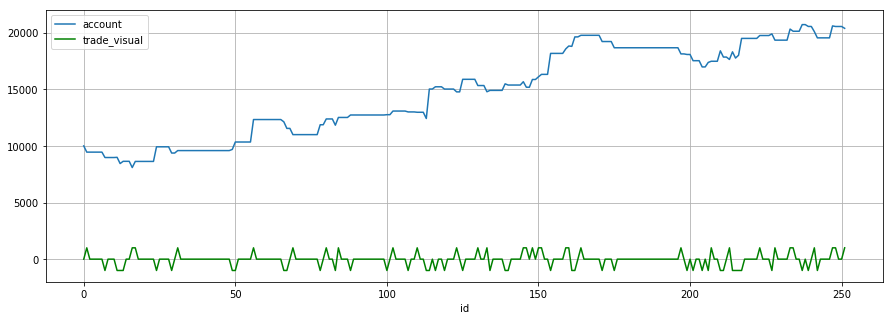

In [314]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=400)
# ax1 = gold_account[['account']].plot(grid=True)
# ax1.set_ylim(0,gold_account.account.max()+500)

In [315]:
y_pred = gold_clf.predict(X_test)

In [316]:
df = pd.DataFrame([])
df['y_true'] = y_test
df['y_pred'] = y_pred
df.corr()

,y_true,y_pred
y_true,1.000000,-0.009491
y_pred,-0.009491,1.000000


In [332]:
X_val = pca_transform(gold_reg_validate, gold_reg_pca)

In [333]:
y_pred_val = gold_clf.predict(X_val)
y_true_val = gold_reg_label_validate

In [337]:
df = pd.DataFrame([])
df['y_true'] = y_true_val
df['y_pred'] = y_pred_val
df.corr()

,y_true,y_pred
y_true,1.000000,0.135486
y_pred,0.135486,1.000000


In [338]:
df[df.y_pred.abs() > 400].corr()

,y_true,y_pred
y_true,1.000000,0.206823
y_pred,0.206823,1.000000


In [320]:
(gold_account.account.values[-1]/gold_account.account.values[0])*100-100

103.81499999999971

In [341]:
# source https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(df[df.y_pred.abs() > 400].y_true - df[df.y_pred.abs() > 400].y_pred, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=df[df.y_pred.abs() > 400].y_pred, y=df[df.y_pred.abs() > 400].y_true)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)

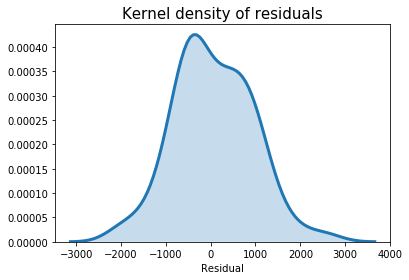

In [342]:
plot_residual_distribution(gold_clf)

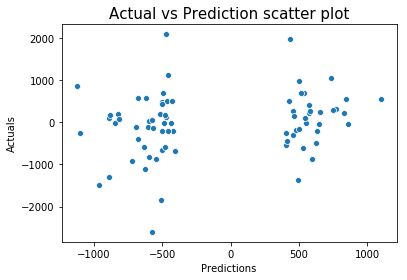

In [343]:
plot_scatter_pred_actual(gold_clf)

In [324]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's poisson: 69.598
[2]	valid_0's poisson: -128.884
[3]	valid_0's poisson: -332.009
[4]	valid_0's poisson: -439.846
[5]	valid_0's poisson: -359.619
[6]	valid_0's poisson: -427.408
[7]	valid_0's poisson: -486.111
[8]	valid_0's poisson: -329.157
[9]	valid_0's poisson: -367.137
[10]	valid_0's poisson: -186.327
[11]	valid_0's poisson: -422.776
[12]	valid_0's poisson: -373.216
[13]	valid_0's poisson: -387.282
[14]	valid_0's poisson: -397.331
[15]	valid_0's poisson: -320.711
[16]	valid_0's poisson: -303.268
[17]	valid_0's poisson: -315.614
[18]	valid_0's poisson: -399.458
[19]	valid_0's poisson: -341.88
[20]	valid_0's poisson: -428.59
[21]	valid_0's poisson: -235.66
[22]	valid_0's poisson: -130.051
[23]	valid_0's poisson: -87.8415
[24]	valid_0's poisson: -147.984
[25]	valid_0's poisson: -39.772
[26]	valid_0's poisson: -83.8672
[27]	valid_0's poisson: -11.9027
[28]	valid_0's poisson: -39.8051
[29]	valid_0's poisson: 10.3781
[30]	valid_0's poisson: -59.4031
[31]	valid_0's poisson: -4

[284]	valid_0's poisson: 77.6912
[285]	valid_0's poisson: 77.8588
[286]	valid_0's poisson: 78.0341
[287]	valid_0's poisson: 77.8325
[288]	valid_0's poisson: 77.77
[289]	valid_0's poisson: 72.4957
[290]	valid_0's poisson: 72.3689
[291]	valid_0's poisson: 72.4296
[292]	valid_0's poisson: 77.7943
[293]	valid_0's poisson: 78.3558
[294]	valid_0's poisson: 83.4926
[295]	valid_0's poisson: 77.7284
[296]	valid_0's poisson: 77.6296
[297]	valid_0's poisson: 83.3018
[298]	valid_0's poisson: 83.2145
[299]	valid_0's poisson: 83.3482
[300]	valid_0's poisson: 83.4079
[301]	valid_0's poisson: 83.2928
[302]	valid_0's poisson: 83.0702
[303]	valid_0's poisson: 83.1061
[304]	valid_0's poisson: 83.3939
[305]	valid_0's poisson: 83.3941
[306]	valid_0's poisson: 83.0544
[307]	valid_0's poisson: 77.0381
[308]	valid_0's poisson: 77.0289
[309]	valid_0's poisson: 76.9303
[310]	valid_0's poisson: 76.9626
[311]	valid_0's poisson: 76.7813
[312]	valid_0's poisson: 76.394
[313]	valid_0's poisson: 76.6319
[314]	valid_0

[560]	valid_0's poisson: 62.3794
[561]	valid_0's poisson: 62.376
[562]	valid_0's poisson: 62.3759
[563]	valid_0's poisson: 62.3753
[564]	valid_0's poisson: 62.3828
[565]	valid_0's poisson: 62.3793
[566]	valid_0's poisson: 62.3806
[567]	valid_0's poisson: 62.3875
[568]	valid_0's poisson: 62.3904
[569]	valid_0's poisson: 62.397
[570]	valid_0's poisson: 62.3923
[571]	valid_0's poisson: 62.4057
[572]	valid_0's poisson: 62.4057
[573]	valid_0's poisson: 62.4078
[574]	valid_0's poisson: 62.4221
[575]	valid_0's poisson: 62.4278
[576]	valid_0's poisson: 62.4335
[577]	valid_0's poisson: 62.4387
[578]	valid_0's poisson: 62.4389
[579]	valid_0's poisson: 62.4423
[580]	valid_0's poisson: 62.4486
[581]	valid_0's poisson: 62.4474
[582]	valid_0's poisson: 62.459
[583]	valid_0's poisson: 62.4635
[584]	valid_0's poisson: 62.4705
[585]	valid_0's poisson: 62.4727
[586]	valid_0's poisson: 62.4749
[587]	valid_0's poisson: 62.4719
[588]	valid_0's poisson: 62.4861
[589]	valid_0's poisson: 62.4344
[590]	valid_0

[815]	valid_0's poisson: 62.4023
[816]	valid_0's poisson: 62.4019
[817]	valid_0's poisson: 62.4025
[818]	valid_0's poisson: 62.402
[819]	valid_0's poisson: 62.4032
[820]	valid_0's poisson: 62.4062
[821]	valid_0's poisson: 62.4096
[822]	valid_0's poisson: 62.4087
[823]	valid_0's poisson: 62.4068
[824]	valid_0's poisson: 62.4094
[825]	valid_0's poisson: 62.4098
[826]	valid_0's poisson: 62.4139
[827]	valid_0's poisson: 62.4174
[828]	valid_0's poisson: 62.4165
[829]	valid_0's poisson: 62.419
[830]	valid_0's poisson: 62.4166
[831]	valid_0's poisson: 62.4
[832]	valid_0's poisson: 62.4011
[833]	valid_0's poisson: 62.4043
[834]	valid_0's poisson: 62.4043
[835]	valid_0's poisson: 62.3998
[836]	valid_0's poisson: 62.3881
[837]	valid_0's poisson: 62.3837
[838]	valid_0's poisson: 62.3824
[839]	valid_0's poisson: 62.3854
[840]	valid_0's poisson: 62.3876
[841]	valid_0's poisson: 62.3885
[842]	valid_0's poisson: 62.3889
[843]	valid_0's poisson: 62.3855
[844]	valid_0's poisson: 62.3857
[845]	valid_0's

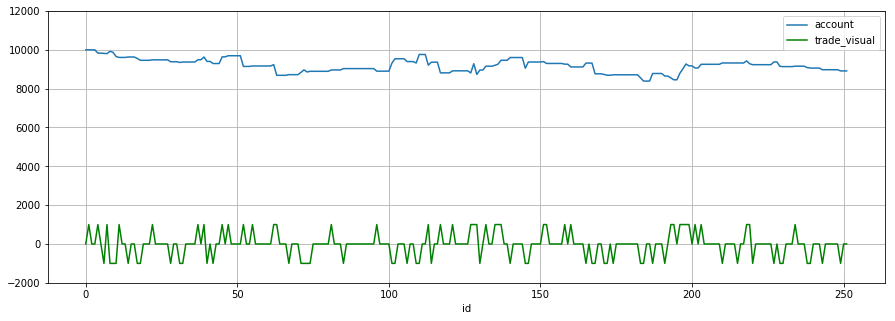

In [325]:
corn_account = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=100)

In [326]:
(corn_account.account.values[-1]/corn_account.account.values[0])*100-100

-10.85875

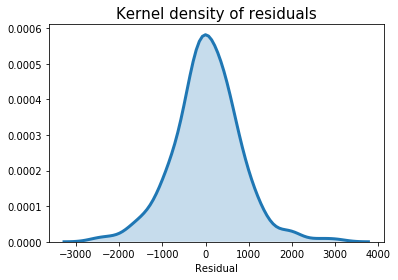

In [327]:
plot_residual_distribution(corn_clf)

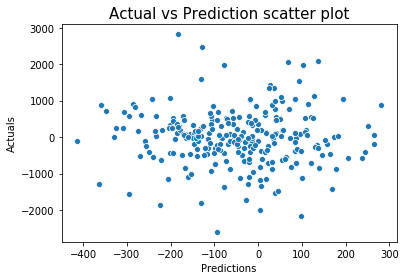

In [328]:
plot_scatter_pred_actual(corn_clf)

In [329]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's poisson: 316.635
[2]	valid_0's poisson: 316.635
[3]	valid_0's poisson: 316.635
[4]	valid_0's poisson: 316.635
[5]	valid_0's poisson: 316.635
[6]	valid_0's poisson: 316.635
[7]	valid_0's poisson: 316.635
[8]	valid_0's poisson: 316.635
[9]	valid_0's poisson: 316.635
[10]	valid_0's poisson: 316.635
[11]	valid_0's poisson: 316.635
[12]	valid_0's poisson: 316.635
[13]	valid_0's poisson: 316.635
[14]	valid_0's poisson: 316.635
[15]	valid_0's poisson: 316.635
[16]	valid_0's poisson: 316.635
[17]	valid_0's poisson: 316.635
[18]	valid_0's poisson: 316.635
[19]	valid_0's poisson: 316.635
[20]	valid_0's poisson: 316.635
[21]	valid_0's poisson: 316.635
[22]	valid_0's poisson: 316.635
[23]	valid_0's poisson: 316.635
[24]	valid_0's poisson: 316.635
[25]	valid_0's poisson: 316.635
[26]	valid_0's poisson: 316.635
[27]	valid_0's poisson: 316.635
[28]	valid_0's poisson: 316.635
[29]	valid_0's poisson: 316.635
[30]	valid_0's poisson: 316.635
[31]	valid_0's poisson: 316.635
[32]	valid_0's po

[254]	valid_0's poisson: 316.635
[255]	valid_0's poisson: 316.635
[256]	valid_0's poisson: 316.635
[257]	valid_0's poisson: 316.635
[258]	valid_0's poisson: 316.635
[259]	valid_0's poisson: 316.635
[260]	valid_0's poisson: 316.635
[261]	valid_0's poisson: 316.635
[262]	valid_0's poisson: 316.635
[263]	valid_0's poisson: 316.635
[264]	valid_0's poisson: 316.635
[265]	valid_0's poisson: 316.635
[266]	valid_0's poisson: 316.635
[267]	valid_0's poisson: 316.635
[268]	valid_0's poisson: 316.635
[269]	valid_0's poisson: 316.635
[270]	valid_0's poisson: 316.635
[271]	valid_0's poisson: 316.635
[272]	valid_0's poisson: 316.635
[273]	valid_0's poisson: 316.635
[274]	valid_0's poisson: 316.635
[275]	valid_0's poisson: 316.635
[276]	valid_0's poisson: 316.635
[277]	valid_0's poisson: 316.635
[278]	valid_0's poisson: 316.635
[279]	valid_0's poisson: 316.635
[280]	valid_0's poisson: 316.635
[281]	valid_0's poisson: 316.635
[282]	valid_0's poisson: 316.635
[283]	valid_0's poisson: 316.635
[284]	vali

[536]	valid_0's poisson: 316.635
[537]	valid_0's poisson: 316.635
[538]	valid_0's poisson: 316.635
[539]	valid_0's poisson: 316.635
[540]	valid_0's poisson: 316.635
[541]	valid_0's poisson: 316.635
[542]	valid_0's poisson: 316.635
[543]	valid_0's poisson: 316.635
[544]	valid_0's poisson: 316.635
[545]	valid_0's poisson: 316.635
[546]	valid_0's poisson: 316.635
[547]	valid_0's poisson: 316.635
[548]	valid_0's poisson: 316.635
[549]	valid_0's poisson: 316.635
[550]	valid_0's poisson: 316.635
[551]	valid_0's poisson: 316.635
[552]	valid_0's poisson: 316.635
[553]	valid_0's poisson: 316.635
[554]	valid_0's poisson: 316.635
[555]	valid_0's poisson: 316.635
[556]	valid_0's poisson: 316.635
[557]	valid_0's poisson: 316.635
[558]	valid_0's poisson: 316.635
[559]	valid_0's poisson: 316.635
[560]	valid_0's poisson: 316.635
[561]	valid_0's poisson: 316.635
[562]	valid_0's poisson: 316.635
[563]	valid_0's poisson: 316.635
[564]	valid_0's poisson: 316.635
[565]	valid_0's poisson: 316.635
[566]	vali

[815]	valid_0's poisson: 316.635
[816]	valid_0's poisson: 316.635
[817]	valid_0's poisson: 316.635
[818]	valid_0's poisson: 316.635
[819]	valid_0's poisson: 316.635
[820]	valid_0's poisson: 316.635
[821]	valid_0's poisson: 316.635
[822]	valid_0's poisson: 316.635
[823]	valid_0's poisson: 316.635
[824]	valid_0's poisson: 316.635
[825]	valid_0's poisson: 316.635
[826]	valid_0's poisson: 316.635
[827]	valid_0's poisson: 316.635
[828]	valid_0's poisson: 316.635
[829]	valid_0's poisson: 316.635
[830]	valid_0's poisson: 316.635
[831]	valid_0's poisson: 316.635
[832]	valid_0's poisson: 316.635
[833]	valid_0's poisson: 316.635
[834]	valid_0's poisson: 316.635
[835]	valid_0's poisson: 316.635
[836]	valid_0's poisson: 316.635
[837]	valid_0's poisson: 316.635
[838]	valid_0's poisson: 316.635
[839]	valid_0's poisson: 316.635
[840]	valid_0's poisson: 316.635
[841]	valid_0's poisson: 316.635
[842]	valid_0's poisson: 316.635
[843]	valid_0's poisson: 316.635
[844]	valid_0's poisson: 316.635
[845]	vali

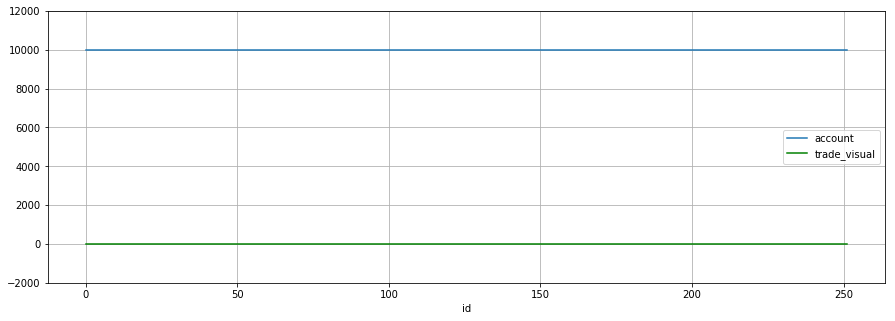

In [330]:
coffee_account = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20)

# Neural Networks classifier

- gold 187% gains (only shorts were triggered)
- corn 

In [87]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [88]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [89]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
opt = Nadam(lr=0.002)
model = define_model(input_shape, num_classes)

In [90]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [91]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])

model.summary()

Train on 1932 samples, validate on 484 samples
Epoch 1/10
1932/1932 [==============================] - 2s 815us/step - loss: 15347006379.9917 - acc: 0.3551 - val_loss: 3437398094.2810 - val_acc: 0.3140

Epoch 00001: val_loss improved from inf to 3437398094.28099, saving model to saved_models/weights.gold.hdf5
Epoch 2/10
1932/1932 [==============================] - 0s 232us/step - loss: 1540557044.5052 - acc: 0.3178 - val_loss: 311162092.6281 - val_acc: 0.2851

Epoch 00002: val_loss improved from 3437398094.28099 to 311162092.62810, saving model to saved_models/weights.gold.hdf5
Epoch 3/10
1932/1932 [==============================] - 0s 242us/step - loss: 125518024.0707 - acc: 0.3028 - val_loss: 17462607.5826 - val_acc: 0.2665

Epoch 00003: val_loss improved from 311162092.62810 to 17462607.58264, saving model to saved_models/weights.gold.hdf5
Epoch 4/10
1932/1932 [==============================] - 0s 246us/step - loss: 6329186.7377 - acc: 0.3463 - val_loss: 601870.1369 - val_acc: 0.260

In [92]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

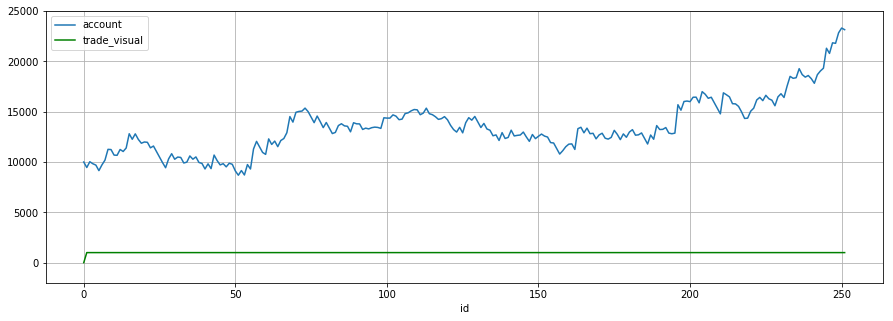

In [93]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [94]:
gold_account_nn[gold_account_nn['short'] == 1].gains.sum()

0.0

In [95]:
gold_account_nn[gold_account_nn['long'] == 1].gains.sum()

13143.50000000004

In [96]:
(gold_account_nn.account.values[-1]/gold_account_nn.account.values[0])*100-100

131.4350000000005

In [97]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1929 samples, validate on 483 samples
Epoch 1/10
1929/1929 [==============================] - 1s 774us/step - loss: 3831475742.4116 - acc: 0.3116 - val_loss: 26040403.8727 - val_acc: 0.3064

Epoch 00001: val_loss improved from inf to 26040403.87267, saving model to saved_models/weights.corn.hdf5
Epoch 2/10
1929/1929 [==============================] - 0s 244us/step - loss: 4792321.7192 - acc: 0.3427 - val_loss: 43228.7090 - val_acc: 0.3975

Epoch 00002: val_loss improved from 26040403.87267 to 43228.70899, saving model to saved_models/weights.corn.hdf5
Epoch 3/10
1929/1929 [==============================] - 0s 253us/step - loss: 7437.9854 - acc: 0.3406 - val_loss: 186.1899 - val_acc: 0.3975

Epoch 00003: val_loss improved from 43228.70899 to 186.18986, saving model to saved_models/weights.corn.hdf5
Epoch 4/10
1929/1929 [==============================] - 0s 232us/step - loss: 90.5615 - acc: 0.3406 - val_loss: 27.6216 - val_acc: 0.3975

Epoch 00004: val_loss improved from 186.189

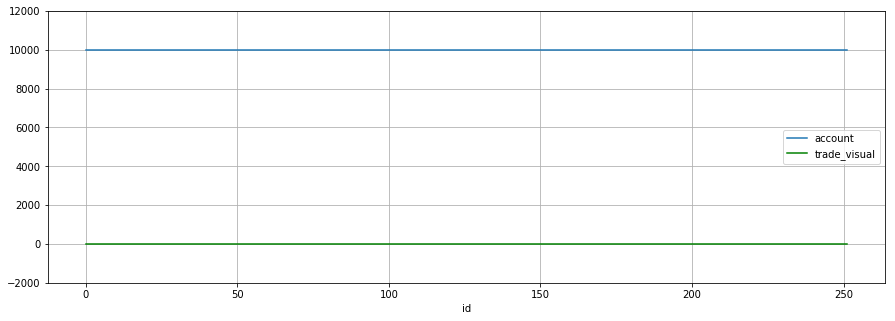

In [98]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [162]:
import keras
import tensorflow as tf
# from sklearn.metrics import mean_squared_error
from tensorflow.losses import mean_squared_error


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.5)


# loss = huber_loss
loss = weighted_mean_squared_error

def regressor_model():
    global input_shape
    global loss
    # Define a model
    #     model = Sequential()  
    #     model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.4))
    #     model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.3))
    #     model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.2))
    #     # model.add(Dense(1))
    #     # model.add(Activation('tanh'))
    #     model.add(Dense(1, kernel_initializer='normal'))
    
    alpha=.00001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',
                   activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(250, kernel_initializer='normal',activation='relu',
                   activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',
                   activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',
                   activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',
                   activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='Adamax')
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [163]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 100
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [164]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1932 samples, validate on 484 samples
Epoch 1/100
1932/1932 [==============================] - 3s 2ms/step - loss: 110290978557.3499 - val_loss: 61413324723.8347

Epoch 00001: val_loss improved from inf to 61413324723.83471, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/100
1932/1932 [==============================] - 1s 356us/step - loss: 46717326923.2629 - val_loss: 30790261417.2562

Epoch 00002: val_loss improved from 61413324723.83471 to 30790261417.25620, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/100
1932/1932 [==============================] - 1s 347us/step - loss: 24701519002.7660 - val_loss: 16892849864.9917

Epoch 00003: val_loss improved from 30790261417.25620 to 16892849864.99174, saving model to saved_models/weights.gold_reg.hdf5
Epoch 4/100
1932/1932 [==============================] - 1s 349us/step - loss: 13782008710.0952 - val_loss: 9515138871.0083

Epoch 00004: val_loss improved from 16892849864.99174 to 9515138871.00826, saving mo

1932/1932 [==============================] - 1s 364us/step - loss: 18941165.5631 - val_loss: 29951713.8306

Epoch 00039: val_loss did not improve from 842473.95467
Epoch 40/100
1932/1932 [==============================] - 1s 427us/step - loss: 48261315.3209 - val_loss: 56880630.2810

Epoch 00040: val_loss did not improve from 842473.95467
Epoch 41/100
1932/1932 [==============================] - 1s 365us/step - loss: 60723324.2692 - val_loss: 63313350.2603

Epoch 00041: val_loss did not improve from 842473.95467
Epoch 42/100
1932/1932 [==============================] - 1s 355us/step - loss: 72285701.8344 - val_loss: 62432950.0083

Epoch 00042: val_loss did not improve from 842473.95467
Epoch 43/100
1932/1932 [==============================] - 1s 357us/step - loss: 67915963.7101 - val_loss: 57040185.7268

Epoch 00043: val_loss did not improve from 842473.95467
Epoch 44/100
1932/1932 [==============================] - 1s 366us/step - loss: 78625576.6998 - val_loss: 54919656.2252

Epoch 0

1932/1932 [==============================] - 1s 358us/step - loss: 118751740.1863 - val_loss: 98325004.5785

Epoch 00085: val_loss did not improve from 842473.95467
Epoch 86/100
1932/1932 [==============================] - 1s 329us/step - loss: 70813187.9379 - val_loss: 51123142.0661

Epoch 00086: val_loss did not improve from 842473.95467
Epoch 87/100
1932/1932 [==============================] - 1s 351us/step - loss: 42991209.9441 - val_loss: 31674160.6157

Epoch 00087: val_loss did not improve from 842473.95467
Epoch 88/100
1932/1932 [==============================] - 1s 357us/step - loss: 44760406.6004 - val_loss: 60214788.1074

Epoch 00088: val_loss did not improve from 842473.95467
Epoch 89/100
1932/1932 [==============================] - 1s 357us/step - loss: 93910898.0787 - val_loss: 121897638.5785

Epoch 00089: val_loss did not improve from 842473.95467
Epoch 90/100
1932/1932 [==============================] - 1s 351us/step - loss: 92221197.5901 - val_loss: 76407513.3058

Epoch

In [165]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

[[-2.46808633e-01]
 [ 1.19641107e-02]
 [ 1.82787672e-01]
 [-1.33411527e+00]
 [ 9.58522856e-02]
 [ 1.49882153e-01]
 [ 2.60406107e-01]
 [-7.18024611e-01]
 [-1.66022673e-01]
 [-2.06597447e+00]
 [-6.35505104e+00]
 [-1.45320043e-01]
 [-1.65817410e-01]
 [-3.98306489e-01]
 [ 5.81219256e-01]
 [ 9.19860303e-01]
 [ 2.10612670e-01]
 [ 5.43851435e-01]
 [-3.80415857e-01]
 [-1.31611332e-01]
 [-3.02078772e+00]
 [-5.70820332e-01]
 [-3.38492465e+00]
 [-4.81257057e+00]
 [-6.72807097e-01]
 [ 1.18338919e+00]
 [ 2.91809797e-01]
 [ 5.37641287e-01]
 [-2.74393487e+00]
 [-4.49656057e+00]
 [ 1.12079477e+00]
 [ 5.45601785e-01]
 [-1.61992478e+00]
 [-2.54706120e+00]
 [-5.06580448e+00]
 [-3.33797288e+00]
 [-4.63936901e+00]
 [-2.24639916e+00]
 [-1.11216867e+00]
 [-1.76790369e+00]
 [ 6.18241169e-03]
 [ 5.35726622e-02]
 [-1.39689112e+00]
 [-3.38008374e-01]
 [ 2.03639165e-01]
 [ 2.16802910e-01]
 [ 5.65173924e-02]
 [ 8.04650933e-02]
 [-8.69172394e-01]
 [ 2.31739402e-01]
 [ 7.35866368e-01]
 [ 3.50555539e-01]
 [ 8.6861890

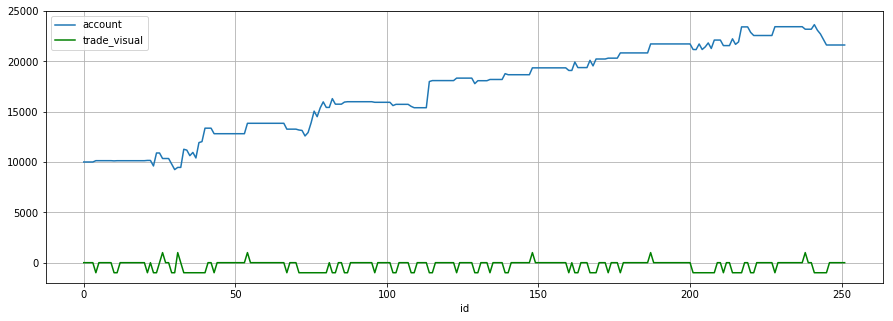

In [212]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=1, debug=True)

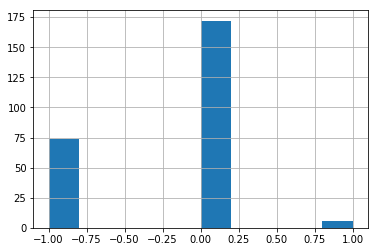

In [213]:
gold_account_nn.trade.hist()

In [235]:
y_pred = np.array([np.asscalar(x) for x in gold_clf_reg_nn.predict(X_test)])

In [236]:
df = pd.DataFrame([])
df['y_true'] = y_test
df['y_pred'] = y_pred
df.corr()

,y_true,y_pred
y_true,1.000000,0.087251
y_pred,0.087251,1.000000


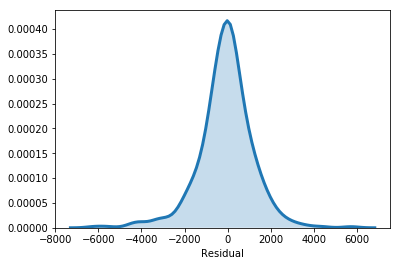

In [215]:
ax = sns.distplot(y_test - [np.asscalar(x) for x in gold_clf_reg_nn.predict(X_test)], hist = False, kde = True,
                  kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")

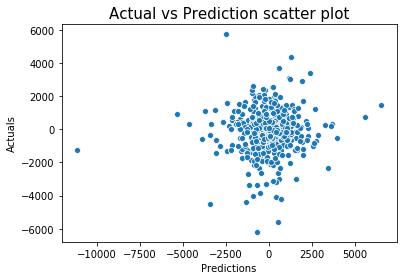

In [188]:
plot_scatter_pred_actual(gold_clf)

In [101]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

loss = huber_loss

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 483 samples
Epoch 1/50
1930/1930 [==============================] - ETA: 28s - loss: 1622.908 - ETA: 1s - loss: 617.4209  - ETA: 0s - loss: 472.271 - 1s 504us/step - loss: 471.1583 - val_loss: 293.6917

Epoch 00001: val_loss improved from inf to 293.69170, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/50
1930/1930 [==============================] - ETA: 0s - loss: 275.075 - ETA: 0s - loss: 310.838 - 0s 57us/step - loss: 313.3542 - val_loss: 294.1699

Epoch 00002: val_loss did not improve from 293.69170
Epoch 3/50
1930/1930 [==============================] - ETA: 0s - loss: 297.662 - ETA: 0s - loss: 309.917 - ETA: 0s - loss: 306.054 - 0s 90us/step - loss: 306.9619 - val_loss: 294.4836

Epoch 00003: val_loss did not improve from 293.69170
Epoch 4/50
1930/1930 [==============================] - ETA: 0s - loss: 393.636 - ETA: 0s - loss: 304.796 - ETA: 0s - loss: 297.653 - ETA: 0s - loss: 297.179 - 0s 96us/step - loss: 300.0996 - val_loss: 294

In [120]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

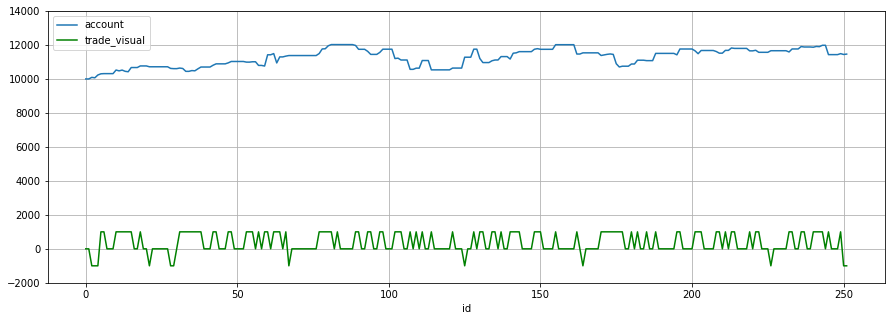

In [121]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=10)

In [ ]:
weights

In [110]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
# X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
# X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

loss = huber_loss

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=50, epochs=50, callbacks=[checkpointer])

Train on 1923 samples, validate on 481 samples
Epoch 1/50
1923/1923 [==============================] - ETA: 36s - loss: 541.99 - ETA: 1s - loss: nan     - ETA: 0s - loss: n - 1s 630us/step - loss: nan - val_loss: 289.2557

Epoch 00001: val_loss improved from inf to 289.25565, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/50
1923/1923 [==============================] - ETA: 0s - loss: 333.253 - ETA: 0s - loss: nan    - 0s 57us/step - loss: nan - val_loss: 289.1837

Epoch 00002: val_loss improved from 289.25565 to 289.18367, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 3/50
1923/1923 [==============================] - ETA: 0s - loss: 359.452 - ETA: 0s - loss: 295.323 - 0s 59us/step - loss: nan - val_loss: 289.1856

Epoch 00003: val_loss did not improve from 289.18367
Epoch 4/50
1923/1923 [==============================] - ETA: 0s - loss: 304.966 - ETA: 0s - loss: 299.303 - ETA: 0s - loss: nan    - 0s 68us/step - loss: nan - val_loss: 289.1189

Epoch 00004: va


Epoch 00035: val_loss did not improve from 289.10371
Epoch 36/50
1923/1923 [==============================] - ETA: 0s - loss: 285.354 - ETA: 0s - loss: nan    - 0s 59us/step - loss: nan - val_loss: 289.2529

Epoch 00036: val_loss did not improve from 289.10371
Epoch 37/50
1923/1923 [==============================] - ETA: 0s - loss: 229.705 - ETA: 0s - loss: nan    - 0s 60us/step - loss: nan - val_loss: 288.9992

Epoch 00037: val_loss improved from 289.10371 to 288.99919, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 38/50
1923/1923 [==============================] - ETA: 0s - loss: 252.626 - ETA: 0s - loss: nan    - 0s 59us/step - loss: nan - val_loss: 289.0256

Epoch 00038: val_loss did not improve from 288.99919
Epoch 39/50
1923/1923 [==============================] - ETA: 0s - loss: 317.979 - ETA: 0s - loss: 285.721 - 0s 59us/step - loss: nan - val_loss: 289.5097

Epoch 00039: val_loss did not improve from 288.99919
Epoch 40/50
1923/1923 [==============================

In [111]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

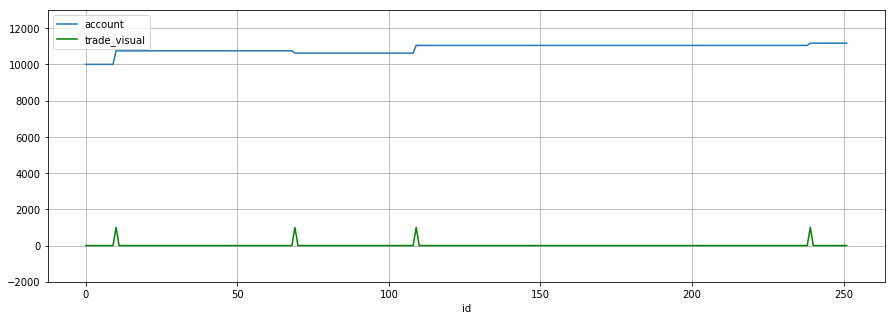

In [127]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=50)

In [91]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [92]:
model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/10
1923/1923 [==============================] - 2s 968us/step - loss: 1345108741.0598 - acc: 0.3703 - val_loss: 118168722.0541 - val_acc: 0.3534

Epoch 00001: val_loss improved from inf to 118168722.05405, saving model to saved_models/weights.coffee.hdf5
Epoch 2/10
1923/1923 [==============================] - 1s 469us/step - loss: 74546425.5624 - acc: 0.3354 - val_loss: 2995577.8018 - val_acc: 0.3493

Epoch 00002: val_loss improved from 118168722.05405 to 2995577.80185, saving model to saved_models/weights.coffee.hdf5
Epoch 3/10
1923/1923 [==============================] - 1s 469us/step - loss: 1452321.3502 - acc: 0.3588 - val_loss: 51528.0584 - val_acc: 0.3493

Epoch 00003: val_loss improved from 2995577.80185 to 51528.05837, saving model to saved_models/weights.coffee.hdf5
Epoch 4/10
1923/1923 [==============================] - 1s 468us/step - loss: 24783.3255 - acc: 0.3796 - val_loss: 1217.0961 - val_acc: 0.3493

Epoch 00004: va

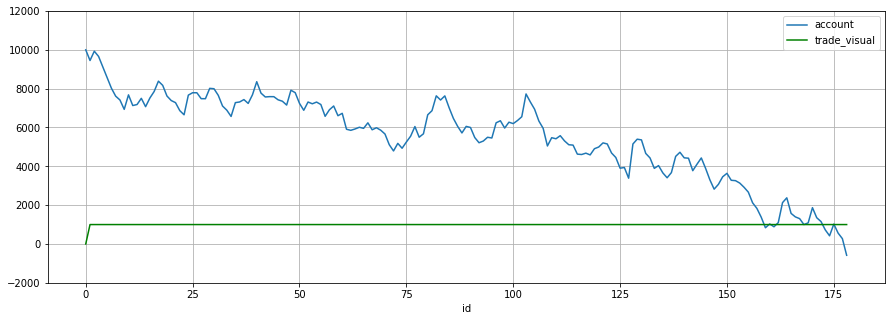

In [93]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [94]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp813w2r31
  JVM stdout: /tmp/tmp813w2r31/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmp813w2r31/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_martin_lp2l29
H2O cluster total nodes:,1
H2O cluster free memory:,3.898 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


In [159]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
print(train.head())
x = train.columns
# print(x)
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,label
-331248,-27640.9,567537,65888,59525.3,252953,55627.8,-128754,107663,-216796,-88335.2,-158876,-132529,109756,-46148.4,-48245.6,102093,-26637.8,30540.3,96452.1,128859,-45519.2,7388.33,-52116.5,-102421,11500.5,193271,43334.5,2318.45,102827,51533.9,86567.1,36590.9,-261.471,-59536.9,-16780.8,-31926.2,7549.36,-39839.9,-36907,-78908.1,38478.6,75299.2,59309.6,-57772.2,-962.663,6690.14,71931.1,-20808.7,7261.05,33567,44209.2,-49242.1,-84342.9,-44027.2,-2084.94,10368.8,38870.4,-613.096,-32479,69451.2,308.221,-13364.1,15870.4,-49266.6,45870.5,63105.2,-35490.1,-65715.3,-4788.1,34259,-20494.4,33098.7,-102350,51410.6,8269.36,-16840.7,108658,17342.1,-1218.5,0
-325632,-21861.3,570463,61896.1,12385.9,263138,67919.7,-122209,98093.2,-221691,-106286,-152934,-113507,123913,-42962.8,-38258.6,83315,-40127.8,40585.4,115445,118744,-60000.3,15372.9,-53794.5,-114798,15974.6,177376,-17248.1,17314,124687,34921.7,80344.1,61220.2,-37308,-29867.1,-1166.26,-41296.1,26294.9,109.477,-68993.8,3021.78,23894.8,104695,12254.5,-66689,-64384.8,41809,42767.2,194.094,-8747.76,-1925.62,38345.7,-77664.3,-54666.2,-75536.2,-25712.6,2171.34,46412,-21732.1,-54354.6,70197.5,24713.4,-44916.4,37495.3,-9355.41,22926.4,98297.6,13941.7,-100836,-23571.8,-11543.4,-25245.6,1870.39,-105292,57833.5,12001.5,-23465.3,69521,-14994.5,50927,1
-322972,-16385.8,569003,64186.8,-29837.6,269476,79430.7,-118529,87320.3,-225986,-112892,-147941,-110230,120907,-33344.8,-40149.1,70584.6,-51203.1,35466.7,134176,101251,-54181.9,32549,-58639.4,-126134,37056.1,155366,-57261.2,40551.1,120155,23424.2,25997.1,2780.28,-89568.8,-15708.8,-1011.36,-68905.6,24145.3,51560,-75562.2,92220.7,8410.63,47008.7,-16419,-70000.6,-96951.1,7842.87,27329.6,19328.6,-28293.3,8712.07,-1664.12,-47051,-6499.19,-42734.9,-39065.3,-10421.2,37505.3,-23146.1,-86740.1,47309.8,49220.8,-50103.9,42567,22345.8,25395,106873,-11562.2,-67847.8,-6094.93,-21463.6,-21262.2,-62921.7,-124364,37153.9,3217.51,14044.9,41059.4,-16838.2,63429.1,1
-316808,-6871.1,569417,64689.3,-75301.1,262696,87154.3,-117425,70892.4,-225472,-119147,-141073,-101452,121946,-29478,-35954.6,52410.8,-54979.7,24516.5,144165,96567.9,-49778.7,49584.8,-63032.9,-129809,59836,140934,-80893.9,70166.7,95379.1,17779,-300.186,-69981.9,-68409.1,-53193.1,-8773.45,-77613.8,-690.233,84757.2,-42160.4,73084.6,5194.72,-13450.3,-4637.24,-40211.7,-82969.9,-74083.9,-7290.44,37658.2,-22197.8,37563.1,-26045.5,5925.39,13381.6,-11238.4,-27809.2,-21976.3,7101.6,-10176.7,-65430.9,7572.18,48541.9,-17773.3,1362.76,57727.9,50370.6,43325.8,-31816.9,-40618.2,-21021.1,45190.8,-927.648,-63506.2,-128467,47232.8,-1175.38,29869.7,43793.4,-20564.1,25002.6,0
-311643,-2933.21,571396,65302.7,-116766,251966,94039.7,-113414,58898.7,-226860,-127331,-131106,-87170.6,123316,-5729.58,-29416.6,27780.2,-63476.6,13070.8,140149,75534.3,-36219.2,68059.3,-64575,-124319,77225.4,122836,-106852,85759.3,57896.1,-4025.9,33095,-69901.3,11078.4,-60444.2,11496.5,-56333.5,-27841.1,62559.1,1880.24,-35582.4,7252.48,672.795,12673.6,32485.4,-45225.6,-106941,-22441.3,39815.6,11214.1,39814,-43807.1,28552.5,4927.01,865.923,-23618.3,-18297.8,17215.7,-20141.2,-8358.09,-36849.8,45296.1,8547.15,-20315.1,51379,36716.6,25751.1,36215.7,-25144.7,-40982.2,56331.2,-16888.3,-21630.9,-81136.2,71368.8,-31081.7,42092.4,-11048.7,-26872.3,-2778.75,0
-310540,3470.74,571167,64108.9,-155840,235912,99022.3,-115409,42634.7,-232187,-129203,-123842,-84895.3,138084,5182.18,-19952.6,11087.3,-58375.5,5129.72,147405,54514.1,-43918.4,75885.3,-68708.9,-125510,98557,111676,-132713,81975.1,31437.4,-42821.1,79131.3,-17202.3,30141,-17240.8,49475.8,-77480.7,-43058.4,29571.4,48094.2,-66596.9,6519.93,40658.5,6558.03,101925,-34460.8,-49257.1,14.6275,42718.4,35107.8,35705.7,-59495.1,23003.7,-13948.8,20768.9,-51227.8,-6901.91,27445.4,-29045.1,23633


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190131_112654,0.5,0.60678,0.5,0.456152,0.208075
StackedEnsemble_BestOfFamily_AutoML_20190131_112654,0.5,0.60678,0.5,0.456152,0.208075
GLM_grid_1_AutoML_20190131_112654_model_1,0.478157,0.6075,0.496698,0.456483,0.208377
DRF_1_AutoML_20190131_112654,0.450022,0.748437,0.5,0.490751,0.240837
XRT_1_AutoML_20190131_112654,0.445851,0.730067,0.496982,0.491442,0.241515


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0589a255c0>]],
      dtype=object)

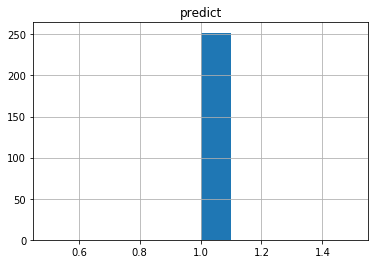

In [130]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

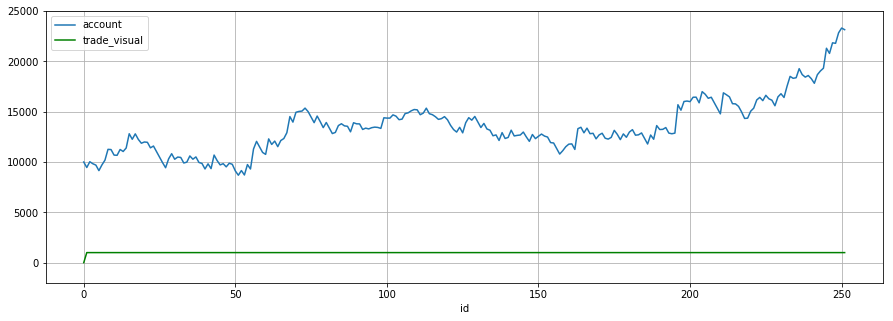

In [131]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [85]:
from sklearn.metrics import f1_score

In [86]:
from sklearn.metrics import confusion_matrix

df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 0 if x < 0 else x).values, df.trade.values)

0.28402366863905326

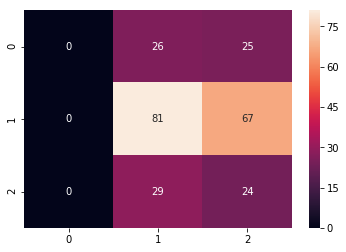

In [87]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [88]:
gold_account['stop_loss'].sum()

26

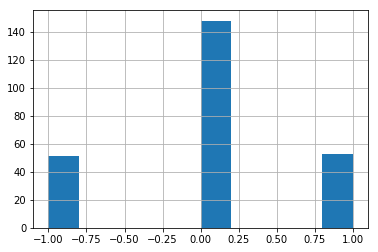

In [89]:
df['label'].hist()

In [163]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
print(train.head())
x = train.columns
y = "80"
x.remove(y)

# For binary classification, response should be a factor
# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()
# validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=3600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
-331248,-27640.9,567537,65888,59525.3,252953,55627.8,-128754,107663,-216796,-88335.2,-158876,-132529,109756,-46148.4,-48245.6,102093,-26637.8,30540.3,96452.1,128859,-45519.2,7388.33,-52116.5,-102421,11500.5,193271,43334.5,2318.45,102827,51533.9,86567.1,36590.9,-261.471,-59536.9,-16780.8,-31926.2,7549.36,-39839.9,-36907,-78908.1,38478.6,75299.2,59309.6,-57772.2,-962.663,6690.14,71931.1,-20808.7,7261.05,33567,44209.2,-49242.1,-84342.9,-44027.2,-2084.94,10368.8,38870.4,-613.096,-32479,69451.2,308.221,-13364.1,15870.4,-49266.6,45870.5,63105.2,-35490.1,-65715.3,-4788.1,34259,-20494.4,33098.7,-102350,51410.6,8269.36,-16840.7,108658,17342.1,-1218.5,-589
-325632,-21861.3,570463,61896.1,12385.9,263138,67919.7,-122209,98093.2,-221691,-106286,-152934,-113507,123913,-42962.8,-38258.6,83315,-40127.8,40585.4,115445,118744,-60000.3,15372.9,-53794.5,-114798,15974.6,177376,-17248.1,17314,124687,34921.7,80344.1,61220.2,-37308,-29867.1,-1166.26,-41296.1,26294.9,109.477,-68993.8,3021.78,23894.8,104695,12254.5,-66689,-64384.8,41809,42767.2,194.094,-8747.76,-1925.62,38345.7,-77664.3,-54666.2,-75536.2,-25712.6,2171.34,46412,-21732.1,-54354.6,70197.5,24713.4,-44916.4,37495.3,-9355.41,22926.4,98297.6,13941.7,-100836,-23571.8,-11543.4,-25245.6,1870.39,-105292,57833.5,12001.5,-23465.3,69521,-14994.5,50927,1757.5
-322972,-16385.8,569003,64186.8,-29837.6,269476,79430.7,-118529,87320.3,-225986,-112892,-147941,-110230,120907,-33344.8,-40149.1,70584.6,-51203.1,35466.7,134176,101251,-54181.9,32549,-58639.4,-126134,37056.1,155366,-57261.2,40551.1,120155,23424.2,25997.1,2780.28,-89568.8,-15708.8,-1011.36,-68905.6,24145.3,51560,-75562.2,92220.7,8410.63,47008.7,-16419,-70000.6,-96951.1,7842.87,27329.6,19328.6,-28293.3,8712.07,-1664.12,-47051,-6499.19,-42734.9,-39065.3,-10421.2,37505.3,-23146.1,-86740.1,47309.8,49220.8,-50103.9,42567,22345.8,25395,106873,-11562.2,-67847.8,-6094.93,-21463.6,-21262.2,-62921.7,-124364,37153.9,3217.51,14044.9,41059.4,-16838.2,63429.1,1054.5
-316808,-6871.1,569417,64689.3,-75301.1,262696,87154.3,-117425,70892.4,-225472,-119147,-141073,-101452,121946,-29478,-35954.6,52410.8,-54979.7,24516.5,144165,96567.9,-49778.7,49584.8,-63032.9,-129809,59836,140934,-80893.9,70166.7,95379.1,17779,-300.186,-69981.9,-68409.1,-53193.1,-8773.45,-77613.8,-690.233,84757.2,-42160.4,73084.6,5194.72,-13450.3,-4637.24,-40211.7,-82969.9,-74083.9,-7290.44,37658.2,-22197.8,37563.1,-26045.5,5925.39,13381.6,-11238.4,-27809.2,-21976.3,7101.6,-10176.7,-65430.9,7572.18,48541.9,-17773.3,1362.76,57727.9,50370.6,43325.8,-31816.9,-40618.2,-21021.1,45190.8,-927.648,-63506.2,-128467,47232.8,-1175.38,29869.7,43793.4,-20564.1,25002.6,-864.5
-311643,-2933.21,571396,65302.7,-116766,251966,94039.7,-113414,58898.7,-226860,-127331,-131106,-87170.6,123316,-5729.58,-29416.6,27780.2,-63476.6,13070.8,140149,75534.3,-36219.2,68059.3,-64575,-124319,77225.4,122836,-106852,85759.3,57896.1,-4025.9,33095,-69901.3,11078.4,-60444.2,11496.5,-56333.5,-27841.1,62559.1,1880.24,-35582.4,7252.48,672.795,12673.6,32485.4,-45225.6,-106941,-22441.3,39815.6,11214.1,39814,-43807.1,28552.5,4927.01,865.923,-23618.3,-18297.8,17215.7,-20141.2,-8358.09,-36849.8,45296.1,8547.15,-20315.1,51379,36716.6,25751.1,36215.7,-25144.7,-40982.2,56331.2,-16888.3,-21630.9,-81136.2,71368.8,-31081.7,42092.4,-11048.7,-26872.3,-2778.75,-522.5
-310540,3470.74,571167,64108.9,-155840,235912,99022.3,-115409,42634.7,-232187,-129203,-123842,-84895.3,138084,5182.18,-19952.6,11087.3,-58375.5,5129.72,147405,54514.1,-43918.4,75885.3,-68708.9,-125510,98557,111676,-132713,81975.1,31437.4,-42821.1,79131.3,-17202.3,30141,-17240.8,49475.8,-77480.7,-43058.4,29571.4,48094.2,-66596.9,6519.93,40658.5,6558.03,101925,-34460.8,-49257.1,14.6275,42718.4,35107.8,35705.7,-59495.1,23003.7,-13948.8,20768.9,-51227.8,-6901.91,27


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190131_112933,1.68303e+06,1297.32,1.68303e+06,895.745,nan
StackedEnsemble_BestOfFamily_AutoML_20190131_112933,1.6838e+06,1297.61,1.6838e+06,896.455,nan
GLM_grid_1_AutoML_20190131_112933_model_1,1.6843e+06,1297.8,1.6843e+06,895.893,nan
GBM_grid_1_AutoML_20190131_112933_model_4,1.6883e+06,1299.35,1.6883e+06,897.028,nan
GBM_grid_1_AutoML_20190131_112933_model_1,1.69312e+06,1301.2,1.69312e+06,898.723,nan
GBM_grid_1_AutoML_20190131_112933_model_3,1.69475e+06,1301.82,1.69475e+06,898.656,nan
GBM_grid_1_AutoML_20190131_112933_model_5,1.69868e+06,1303.34,1.69868e+06,900.334,nan
GBM_5_AutoML_20190131_112933,1.76814e+06,1329.71,1.76814e+06,922.226,nan
DeepLearning_1_AutoML_20190131_112933,1.78268e+06,1335.17,1.78268e+06,943.6,nan
DeepLearning_grid_1_AutoML_20190131_112933_model_3,1.80751e+06,1344.44,1.80751e+06,947.193,nan


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0604541cf8>]],
      dtype=object)

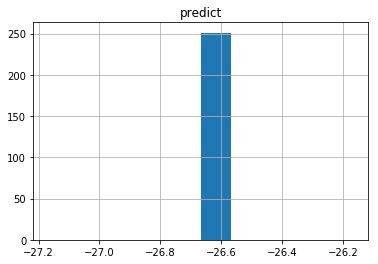

In [164]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [165]:
b

array([-26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66778697,
       -26.66778697, -26.66778697, -26.66778697, -26.66

In [91]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv")
validation = h2o.import_file("data/gold_pca_short_validation.csv")
test = h2o.import_file("data/gold_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
# aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml = H2OAutoML(max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190128_201329_model_1,0.529463,0.602785,0.499635,0.454115,0.206221
GBM_grid_1_AutoML_20190128_201329_model_3,0.524985,0.613129,0.498328,0.458679,0.210387
GBM_grid_1_AutoML_20190128_201329_model_5,0.519633,0.603576,0.498174,0.454527,0.206595
GBM_grid_1_AutoML_20190128_201329_model_7,0.516039,0.720863,0.491557,0.493923,0.24396
DeepLearning_grid_1_AutoML_20190128_201329_model_4,0.514591,0.844366,0.5,0.503284,0.253295
GBM_grid_1_AutoML_20190128_201329_model_4,0.512316,0.604366,0.499059,0.454899,0.206934
XRT_1_AutoML_20190128_201329,0.510556,0.658508,0.494831,0.477138,0.227661
GBM_grid_1_AutoML_20190128_201329_model_1,0.509745,0.60447,0.492245,0.454946,0.206976
GBM_grid_1_AutoML_20190128_201329_model_10,0.509188,1.26487,0.5,0.545884,0.297989
GBM_5_AutoML_20190128_201329,0.507789,0.620216,0.499635,0.461899,0.213351


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679963c18>]],
      dtype=object)

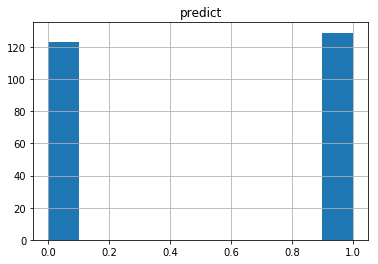

In [92]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

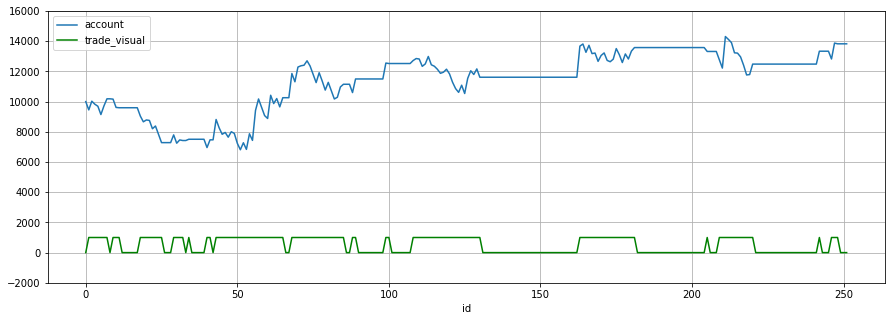

In [93]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [94]:
df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 1 if x == -1 else 0).values, df.trade.map(lambda x: 1 if x == -1 else 0).values)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

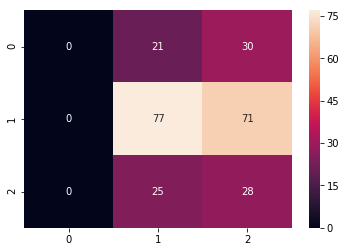

In [95]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [96]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv")
validation = h2o.import_file("data/corn_pca_short_validation.csv")
test = h2o.import_file("data/corn_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190128_202227,0.566971,0.596358,0.479809,0.45116,0.203546
GBM_5_AutoML_20190128_202227,0.566312,0.601107,0.46016,0.453476,0.20564
StackedEnsemble_BestOfFamily_AutoML_20190128_202227,0.563836,0.596511,0.470983,0.451183,0.203566
GBM_grid_1_AutoML_20190128_202227_model_1,0.563351,0.597617,0.467045,0.451631,0.203971
GBM_3_AutoML_20190128_202227,0.556856,0.63072,0.455144,0.463887,0.215191
DeepLearning_grid_1_AutoML_20190128_202227_model_1,0.556806,0.945067,0.47665,0.513596,0.263781
DeepLearning_grid_1_AutoML_20190128_202227_model_2,0.556422,1.57827,0.472329,0.568948,0.323702
GBM_grid_1_AutoML_20190128_202227_model_3,0.556421,0.597966,0.469095,0.451809,0.204131
GBM_1_AutoML_20190128_202227,0.554547,0.623957,0.476599,0.462,0.213444
GBM_grid_1_AutoML_20190128_202227_model_4,0.553946,0.599035,0.465674,0.452275,0.204553


stackedensemble prediction progress: |████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679867048>]],
      dtype=object)

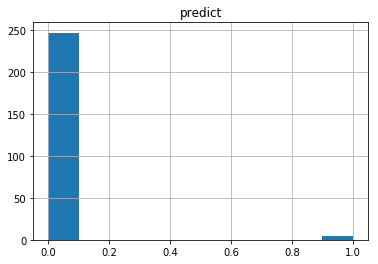

In [97]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

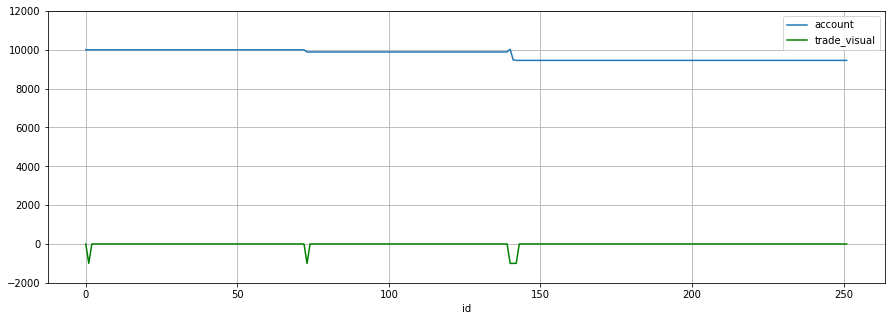

In [98]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [99]:
df = corn_account[['label', 'trade']]
f1_score(df.label.map(lambda x: x if x >= 0 else 0).values, df.trade.map(lambda x: x if x >= 0 else 0).values)

0.0

In [100]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv")
validation = h2o.import_file("data/corn_pca_long_validation.csv")
test = h2o.import_file("data/corn_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190128_202958,0.558644,0.650473,0.461411,0.472367,0.223131
GBM_5_AutoML_20190128_202958,0.553718,0.618722,0.5,0.46185,0.213305
StackedEnsemble_BestOfFamily_AutoML_20190128_202958,0.553311,0.612408,0.5,0.459219,0.210882
GBM_3_AutoML_20190128_202958,0.552521,0.642998,0.484246,0.470982,0.221824
GBM_grid_1_AutoML_20190128_202958_model_1,0.551435,0.613053,0.441366,0.459515,0.211154
GBM_1_AutoML_20190128_202958,0.550972,0.636459,0.485388,0.469166,0.220116
GBM_grid_1_AutoML_20190128_202958_model_3,0.547657,0.613104,0.47288,0.459532,0.211169
GLM_grid_1_AutoML_20190128_202958_model_1,0.543377,0.61379,0.49712,0.459864,0.211475
GBM_2_AutoML_20190128_202958,0.542382,0.639702,0.493638,0.469859,0.220767
StackedEnsemble_AllModels_AutoML_20190128_202958,0.542138,0.613357,0.497224,0.459656,0.211284


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4679bf9c50>]],
      dtype=object)

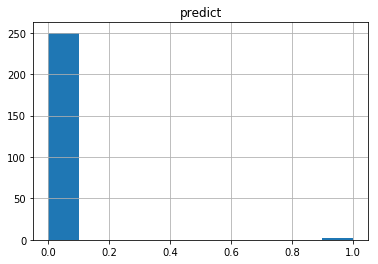

In [101]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

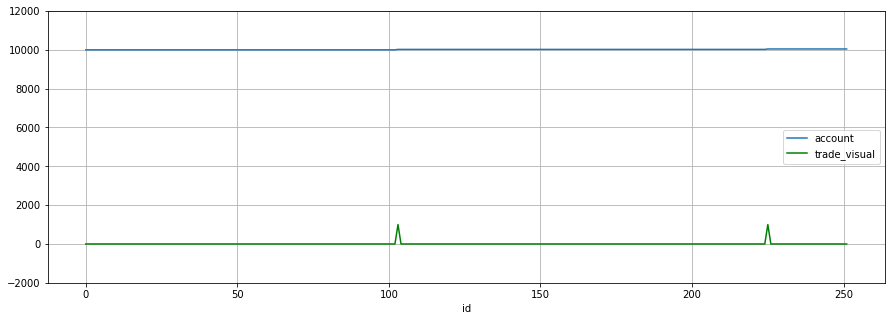

In [102]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long.csv")
test = h2o.import_file("data/coffee_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190128_203653_model_3,0.531394,1.86129,0.5,0.600859,0.361032
GBM_4_AutoML_20190128_203653,0.524811,0.687303,0.498704,0.493061,0.243109
DeepLearning_1_AutoML_20190128_203653,0.523665,0.72496,0.493237,0.500294,0.250294
DeepLearning_grid_1_AutoML_20190128_203653_model_1,0.521768,1.04249,0.5,0.53196,0.282981
StackedEnsemble_BestOfFamily_AutoML_20190128_203653,0.520639,0.652494,0.5,0.479544,0.229963
GBM_1_AutoML_20190128_203653,0.520264,0.677614,0.497395,0.489861,0.239964
StackedEnsemble_AllModels_AutoML_20190128_203653,0.519522,0.652796,0.5,0.479684,0.230096
GBM_5_AutoML_20190128_203653,0.513988,0.661591,0.5,0.483463,0.233737
GBM_2_AutoML_20190128_203653,0.513774,0.68268,0.499028,0.492165,0.242226
DeepLearning_grid_1_AutoML_20190128_203653_model_4,0.512674,2.03851,0.5,0.598494,0.358195


deeplearning prediction progress: |███████████████████████████████████████| 100%


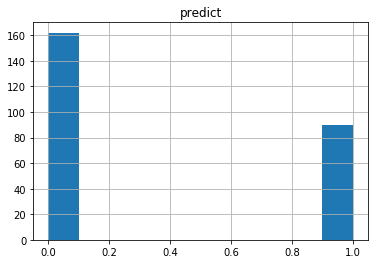

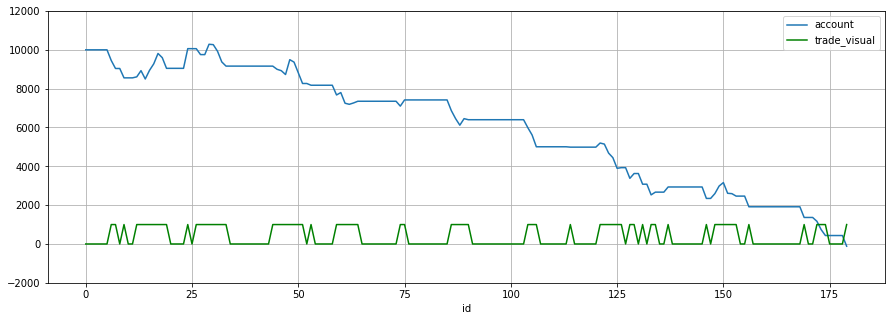

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [105]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short.csv")
test = h2o.import_file("data/coffee_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190128_204356_model_2,0.514271,1.41535,0.5,0.58845,0.346273
GBM_5_AutoML_20190128_204356,0.514097,0.672301,0.5,0.489065,0.239185
XRT_1_AutoML_20190128_204356,0.509603,0.694445,0.497432,0.498639,0.248641
DRF_1_AutoML_20190128_204356,0.509136,0.697951,0.49191,0.500152,0.250152
GBM_1_AutoML_20190128_204356,0.506071,0.695037,0.5,0.498238,0.248241
DeepLearning_grid_1_AutoML_20190128_204356_model_3,0.504641,1.8096,0.5,0.617128,0.380847
DeepLearning_grid_1_AutoML_20190128_204356_model_4,0.501634,1.74159,0.5,0.60757,0.369142
GBM_grid_1_AutoML_20190128_204356_model_5,0.500502,0.66349,0.5,0.485072,0.235295
GBM_grid_1_AutoML_20190128_204356_model_1,0.499309,0.663267,0.5,0.484969,0.235195
GBM_2_AutoML_20190128_204356,0.499267,0.699571,0.499666,0.500289,0.250289


gbm prediction progress: |████████████████████████████████████████████████| 100%


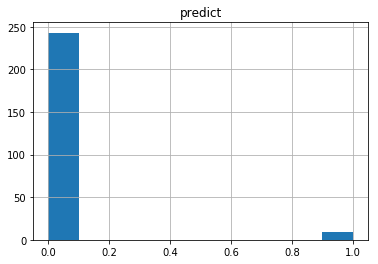

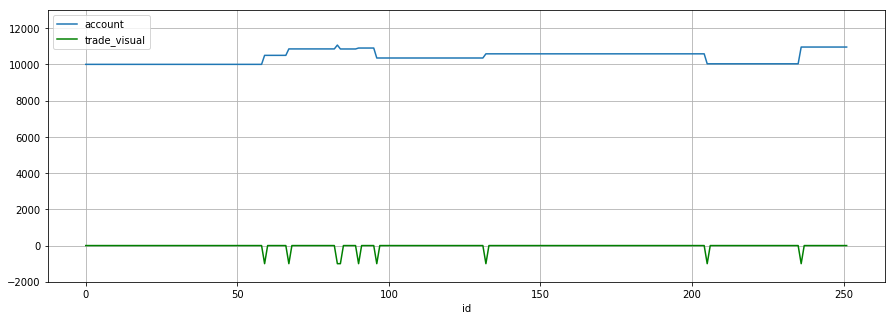

In [106]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [107]:
# %%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = gold_label_train
y_test = gold_label_test

y = np.array(list(map(create_target, y.values)))
y_test = np.array(list(map(create_target, y_test.values)))

In [108]:
input_shape = 90
num_classes = 3

# Define a model
model = Sequential()  
model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

opt = Nadam(lr=0.002)

In [109]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_acc',
                               verbose=1, save_best_only=True,
                               save_weights_only=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=1, epochs=10, callbacks=[checkpointer])

model.summary()

ValueError: Error when checking input: expected dense_13_input to have shape (90,) but got array with shape (80,)

In [ ]:
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_long = model

In [ ]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss=300)
ax1 = corn_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(corn_account_long.account))

In [ ]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

In [ ]:
corn_account_long[corn_account_long['short'] == 1].gains.sum()

In [ ]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

In [ ]:
corn_account_long[['trade', 'label']].hist()

In [ ]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

coffee_clf_long = model
# coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [ ]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=False, stop_loss=1000, vector=True)
ax1 = coffee_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(coffee_account_long.account))

In [87]:
coffee_account_long.head(10)

,account,trade,label,short,long,stop_loss,gains
0,10000.0000,0.0,0.0,0,0,0,0.0000
1,9000.0000,1.0,-1.0,0,1,1,-1000.0000
2,9479.4375,1.0,1.0,0,1,0,479.4375
3,9210.7500,1.0,0.0,0,1,0,-268.6875
4,8210.7500,1.0,-1.0,0,1,1,-1000.0000
5,7210.7500,1.0,0.0,0,1,1,-1000.0000
6,6674.8750,1.0,-1.0,0,1,0,-535.8750
7,6263.6875,1.0,-1.0,0,1,0,-411.1875
8,6066.2500,1.0,0.0,0,1,0,-197.4375
9,5583.8125,1.0,-1.0,0,1,0,-482.4375


In [88]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

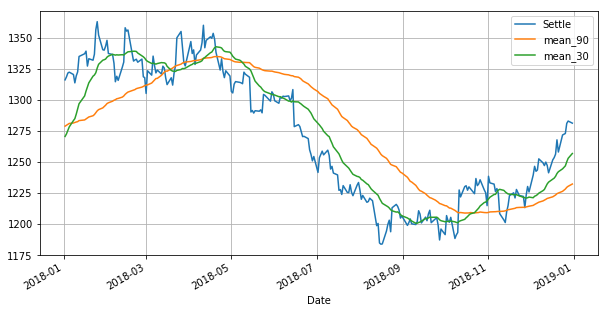

In [89]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)

In [90]:
# dow_amount = 10000/dow[dow.index == '2018-01-01'].Settle
# print(dow.loc[(dow.index >= '2018-01-01') & (dow.index < '2018-01-02')].Settle)
# print(dow_amount)
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]
# dow = dow.loc[(dow.index <= '2018-12-31')]
# gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}).head()

In [91]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [92]:
nasdaq_amount

1.5349783184312522

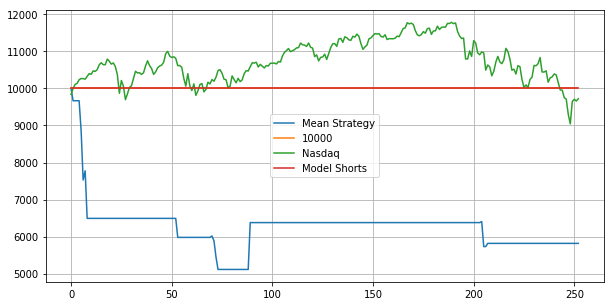

In [93]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)

In [94]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9837.292298
1,9667.5,10000,10000.000000
2,9667.5,10000,10107.064738
3,9667.5,10000,10136.229326
4,9667.5,10000,10234.851683


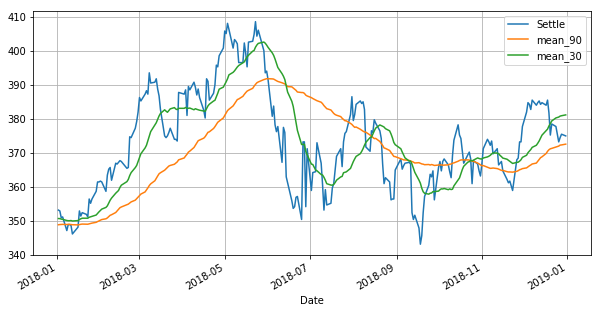

In [95]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

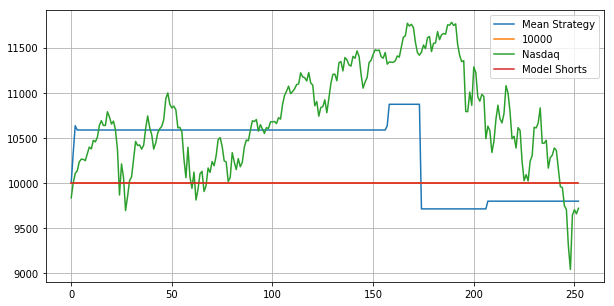

In [96]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5), grid=True)

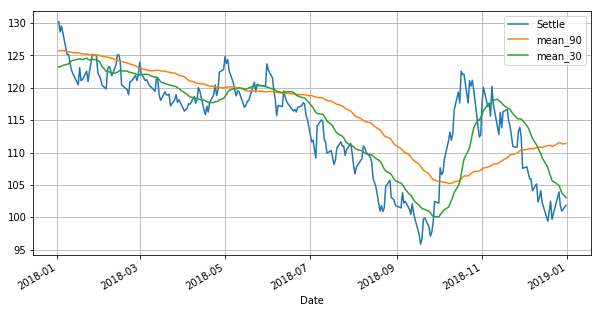

In [97]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

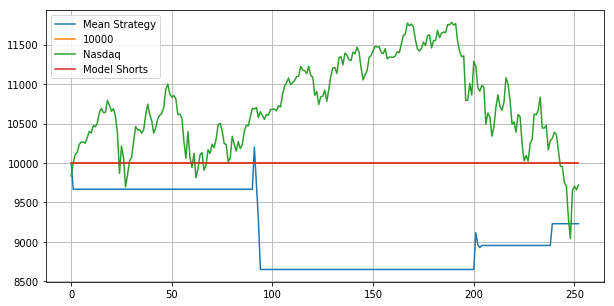

In [98]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)